## CIFAR10 Dataset
This notebook uses convolutional neural networks to classify images in CIFAR10 dataset. The network is built and trained using PyTorch.

**About the data:**
This dataset contains 60,000 images belonging to 10 classes, with 50,000 training examples and 10,000 test examples

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import sys

import matplotlib.pyplot as plt
%matplotlib inline

Our first setp would be to get the training and testing dataset and apply transformations on them.

We will apply two transformations on the data: Convert images to tensors using ```transforms.ToTensor()``` and Normalize the data with mean and standard deviation of 0.5 on all dimensions using ```transforms.Normalize()```. These two transformations are combined using ```transforms.Compose()```.

Then to get the dataset, we will use the ```torchvision``` library and get the training and test data.

These datasets are converted to iterable format by using ```torch.utils.data.DataLoader``` which will divide the dataset into batches.

In [21]:
# Defining training parameters
LEARNING_RATE = 0.01
EPOCHS = 5
BATCH_SIZE = 32
NUM_CLASSES = 10

In [19]:
# Transformations to be applied to the data
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])

# Getting the training and test data
train_data = torchvision.datasets.CIFAR10(root = './data', train = True, transform = transform)
test_data = torchvision.datasets.CIFAR10(root = './data', train = False, transform = transform)

# Creating iterable data loaders for train and test data
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE)

# Class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

The next step is to create a neural network architecture which will be used to train the model.  We create a class ```Net``` which has the network architecture defined. 

Our network architecture is defined as follows:

Input -> Conv2d -> Relu -> MaxPool2d -> Conv2d -> Relu -> MaxPool2d -> Flatten -> Dropout -> Hidden Layer -> Output Layer

This architecture takes a 32x32 colored image as input. After a series of convolutional and max pooling layers, the image is flattened and passed to fully connected layers. The input size of fully connected layer is defined by calculating the output shape of each layer using the formula

$$W_{out} = \frac{W_{in} - F + 2P}{S} + 1$$

Where F is the kernel size, P is padding and S is stride. For max pool, the default value of stride is kernel size and for conv2d the default is 1.

In [70]:
# Creating a neural network architecture
class Net(nn.Module):
    '''
    Input Image size = 32x32 colored
    Number of output labels = 10
    '''
    def __init__(self):
        super(Net, self).__init__()
        
        # conv1 input = (3, 32, 32), output = (8, 30, 30)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3, 3), stride = 1, padding = 0) 
        
        # conv2 input = (8, 30, 30), output = (16, 28, 28)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3), stride = 1, padding = 0)
        
        # pool1 input = (16, 28, 28), output = (16, 14, 14)
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2))
        
        # conv1 input = (16, 14, 14), output = (32, 13, 13)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (2, 2), stride = 1, padding = 0) 
        
        # conv2 input = (32, 13, 13), output = (64, 12, 12)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (2, 2), stride = 1, padding = 0)
        
        # pool2 input = (64, 12, 12), output = (64, 6, 6)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2))
        
        self.dropout = nn.Dropout(p = 0.5)
        
        # fc1 input_features = 32 * 4 * 4, output_features = 256
        self.fc1 = nn.Linear(in_features = 64 * 6 * 6, out_features = 256)
        
        # fc2 input_features = 256, output_features = 128
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        
        # fc3 input_features = 256, output_features = 10
        self.fc3 = nn.Linear(in_features = 128, out_features = NUM_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        x = x.view(-1, self.num_flat_features(x))
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        n_features = 1
        for s in size:
            n_features = n_features * s
        
        return n_features

Next, we will define the loss function and optimizer for this model. For this problem, we choose ```nn.CrossEntropyLoss``` as our loss function. ```nn.CrossEntropyLoss``` combines ```nn.LogSoftmax()``` and ```nn.NLLLoss()``` which is why we do not have the softmax function defined in our model architecture class ```Net```.

In [71]:
# Defining loss and optimizer
model = Net()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [72]:
def drawProgressBar(current, total, string = '', barLen = 20):
    '''
    Draws a progress bar, something like [====>    ] 20%
    
    Parameters
    ------------
    precent: float 
             percentage completed, between 0 and 1
             
    string: str
            Additional details to write along with progress
    
    barLen: int
            Length of progress bar
    '''
    percent = current/total
    arrow = ">"
    if percent == 1:
        arrow = ""
    # Carriage return, returns to the begining of line to owerwrite
    sys.stdout.write("\r")
    sys.stdout.write("Progress: [{:<{}}] {}/{}".format("=" * int(barLen * percent) + arrow, 
                                                         barLen, current, total) + string)
    sys.stdout.flush()

Now that we have everything ready, we proceed to train the model. 

There are two nested loops: one that loops over the number of epochs and another that loops over batches of data.

Steps in the inner loop:
- Enumrating over train_loader which is a sequence of batches, the batch are of the form (input, labels), so they are seperated.
- Then we run the forward pass, first get the predictions from inputs and calculate the loss using our loss function.
- Then we do back propogation. First, the gradients of optimizer are set to zero, then the gradients are calculated from the loss and we perform a step in the optimizer that updates the parameters.
- Then the accuracy is measured to get the performance of our model.

In [73]:
# Training the model
num_train_batches = len(train_loader)
loss_hist = []
acc_hist = []

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ':')
    
    for i, batch in enumerate(train_loader):
        # batch is a tuple of input data and labels
        inputs, labels = batch
        
        # Running forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss_hist.append(loss.item())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Measuring Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct/total
        acc_hist.append(accuracy)
        
        # Printing progress
        if ((i + 1) % 10 == 0) or (i == num_train_batches - 1):
            drawProgressBar((i+1), num_train_batches, 
                            '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    
    print('\n\n')

Epoch 1:
Progress: [====================] 1563/1563	 loss: 2.2980 	 acc: 0.0625


Epoch 2:
Progress: [====================] 1563/1563	 loss: 2.3041 	 acc: 0.0000


Epoch 3:
Progress: [====================] 1563/1563	 loss: 2.3210 	 acc: 0.0625


Epoch 4:
Progress: [====================] 1563/1563	 loss: 2.2863 	 acc: 0.1250


Epoch 5:
Progress: [====================] 1563/1563	 loss: 2.2866 	 acc: 0.0625




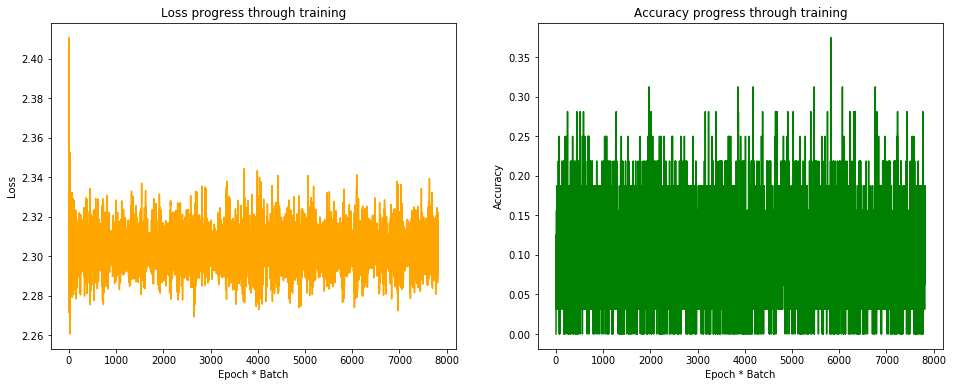

In [74]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist) + 1), loss_hist, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch * Batch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist) + 1), acc_hist, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch * Batch')
ax[1].set_title('Accuracy progress through training')

plt.show()

Now we evalute our model on the test set.

First we put our model in evaluate mode using ```model.eval()``` so that any ```Drouput()``` or ```BatchNormalization()``` layers are removed. 

Then, we use ```torch.no_grad()``` so that we temperoraly stop autograd from tracking history on Tensors and go over all batches in test set to calculate the accuracy.

In [75]:
# Testing the results
model.eval()
num_test_batches = len(test_loader)
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(test_loader):
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim = 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Printing progress
        if ((i + 1) % 10 == 0) or (i == num_test_batches - 1):
            drawProgressBar((i+1), num_test_batches)
            
    print("\n\nTest accuracy: {:.4f}".format(round(correct/total, 4)))

Progress: [====================] 313/313

Test accuracy: 0.1000
